# PageRank Algorithm on Flights Dataset

- author: Kaixin Wang
- UCLA Statistics 202C Final Project
- Spring 2021

In this notebook, we will analyze the Flights dataset using the PageRank algorithm. Flights dataset consists of three data files, `flights.csv`, `airports.csv` and `airlines.csv`, which are collected by the Bureau of Transportation Statistics and are available online at https://www.kaggle.com/usdot/flight-delays.

The `flights.csv` dataset contains the information around 1 million delayed flights in 2015. The `airports.csv` dataset contains the information of 322 airports in the United States. The goal is to analyze which airports are the center for flight delays by calculating the PageRank of each airport.

Recall that the PageRank is a measure of how important a node is inside a graph (or network) described as a probability. The general formula for computing the PageRank is as follows:

\begin{equation} PR(i) = \frac{1-d}{N} + d \sum_{j \in M(i)} \frac{PR(j)}{L(j)}, i = 1, ..., \end{equation}

where $PR(i)$ represents the PageRank of node $i$, $d$ is the damping factor (typically has the value of 0.85), $N$ is the total number of nodes, $M(i)$ is the set of nodes that have outbound links to node $i$, and $L(j)$ is the number of outbound links that node $j$ has. 

## Preparation

### Library Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data Import

In [2]:
flights = pd.read_csv("flights.csv")
airports = pd.read_csv("airports.csv", index_col = 0)
airlines = pd.read_csv("airlines.csv", index_col = 0)

In [3]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
airports.head()

,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
IATA_CODE,,,,,,
ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
airlines.head()

,AIRLINE
IATA_CODE,
UA,United Air Lines Inc.
AA,American Airlines Inc.
US,US Airways Inc.
F9,Frontier Airlines Inc.
B6,JetBlue Airways


### Preliminary Analysis

Using the Python package `networkkx`, we can visualize the flights network. For example, the figure below shows all airports that have flights going to LAX (left) and JFK (right):

In [6]:
import networkx as nx
LAX = nx.from_pandas_edgelist(flights.loc[flights["DESTINATION_AIRPORT"] == "LAX", :], 
                             source='ORIGIN_AIRPORT', target='DESTINATION_AIRPORT', 
                             edge_attr=True)
SFO = nx.from_pandas_edgelist(flights.loc[flights["DESTINATION_AIRPORT"] == "JFK", :], 
                             source='ORIGIN_AIRPORT', target='DESTINATION_AIRPORT', 
                             edge_attr=True)

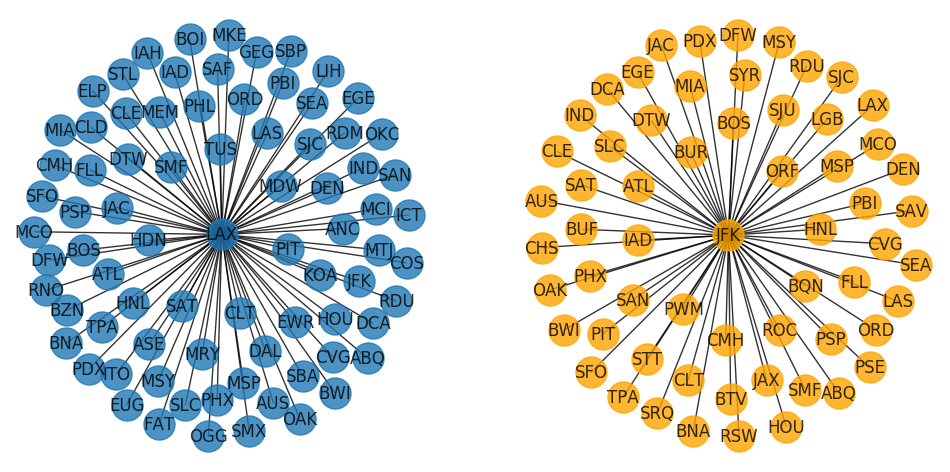

In [24]:
plt.figure(figsize=(12,6), dpi=100)
plt.subplot(1,2,1)
nx.draw(LAX, with_labels = True, node_size=500, alpha=0.8)
plt.subplot(1,2,2)
nx.draw(SFO, with_labels = True, node_size=500, node_color="orange", alpha=0.8)

## PageRank Algorithm

### Build the Directed Graph of Airports

In [8]:
# get the airport code from airports dataset
code = airports.index
n = code.shape[0]
n

322

In [9]:
# create an empty data frame to store the directed graph
graph = np.zeros([n, n])
graph = pd.DataFrame(graph)
graph.columns = code
graph.index = code
graph.head()

IATA_CODE,ABE,ABI,ABQ,ABR,ABY,ACK,ACT,ACV,ACY,ADK,...,TYS,UST,VEL,VLD,VPS,WRG,WYS,XNA,YAK,YUM
IATA_CODE,,,,,,,,,,,,,,,,,,,,,
ABE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# loop through all flights and record the adjacency relations
for i in range(flights.shape[0]):
    flight = flights.iloc[[i], :]
    departure = flight["ORIGIN_AIRPORT"].values[0]
    arrival = flight["DESTINATION_AIRPORT"].values[0]
    if departure in graph.columns and arrival in graph.columns:
        if graph.loc[departure, arrival] == 0:
            graph.loc[departure, arrival] = 1

In [11]:
## save the graph to a csv file for re-use
# graph.to_csv("Graph_flights.csv", index=True)
# graph = pd.read_csv("Graph_flights.csv", index_col=0)

### PageRank Implementations

#### Initializations

In [12]:
N = graph.shape[0]
# initial PageRank vector
p = np.tile(1/N, N)
p = p.reshape(N, 1)
# count vector
c = np.sum(graph, axis=0)
# C^{-1}
C_inv = np.diag(1/c)
# damping factor
d = 0.85

#### Implementation

In [13]:
# n: number of iterations
n = 50
# array to store the PageRank values in each iteration
pageranks = np.zeros([N, n])
pageranks[:, [0]] = p
# main algorithm
for i in range(1, n):
    p = pageranks[:, [i-1]]
    result = C_inv @ p
    result[np.isinf(result)] = 0
    result = d * graph.values.T @ result
    pageranks[:, [i]] = (1-d) / N + result

#### Convergence of PageRank

In [14]:
# convert to a data frame
pageranks = pd.DataFrame(pageranks)
pageranks.index = graph.index

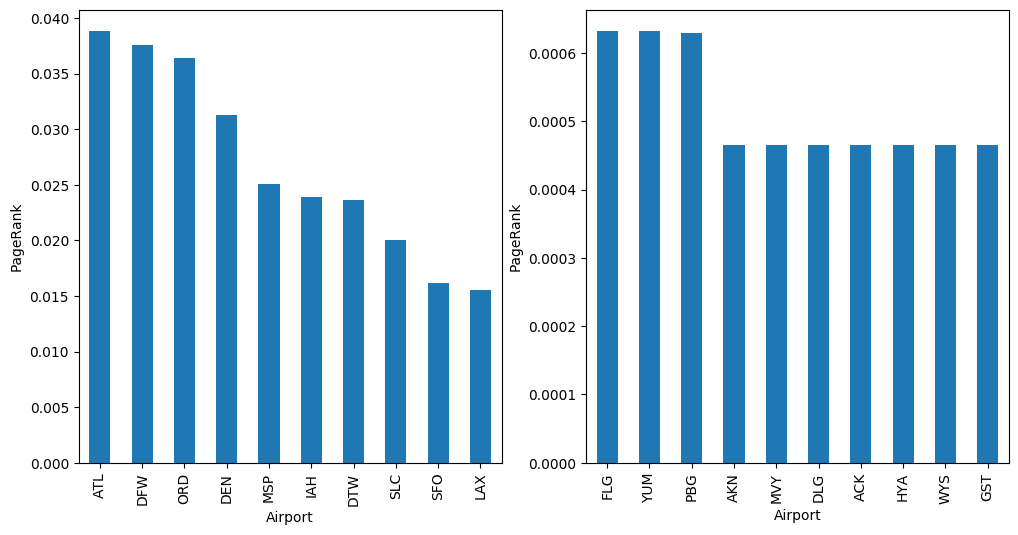

In [15]:
plt.figure(figsize=(12,6), dpi=100)
plt.subplot(1,2,1)
# top 10 airports
pageranks.iloc[:, -1].sort_values(ascending=False).head(10).plot(kind="bar")
plt.ylabel("PageRank")
plt.xlabel("Airport")
plt.subplot(1,2,2)
# bottom 10 airports
pageranks.iloc[:, -1].sort_values(ascending=False).tail(10).plot(kind="bar")
plt.ylabel("PageRank")
plt.xlabel("Airport")
plt.show()

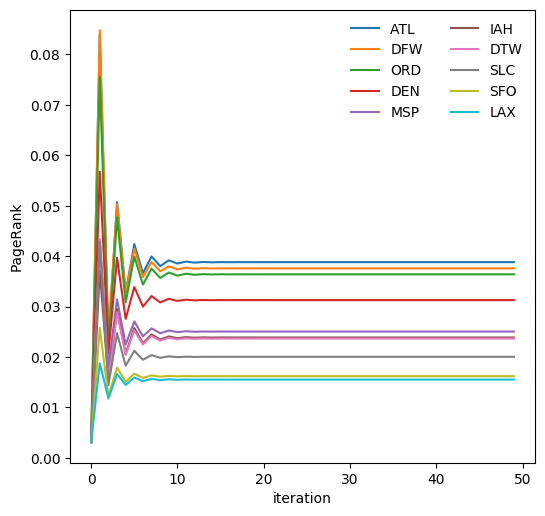

In [16]:
# convergence of top 10 airports
plt.figure(figsize=(6,6), dpi=100)
top = pageranks.iloc[:, -1].sort_values(ascending=False).head(10)
for i in range(top.shape[0]):
    plt.plot(pageranks.loc[top.index[i], :], label=top.index[i])
plt.xlabel("iteration")
plt.ylabel("PageRank")
plt.legend(frameon=False, ncol=2)
plt.show()

## Results and Analysis

### Import `geopandas` and dependencies

In [17]:
# need to download geopandas and its dependencies before use
# import descartes
# import shapely
# import fiona
# import rtree
# import pyproj
import geopandas as gpd
from shapely.geometry import Point, Polygon

### Create a `geopandas` data frame

In [18]:
# create the geometry points
geometry = [Point(xy) for xy in zip(airports["LONGITUDE"], airports["LATITUDE"])]
# define the CRS code
crs = {"init":"epsg:4326"}
# create the geodataframe
geo_df = gpd.GeoDataFrame(pageranks.iloc[:, [-1]], crs = crs, geometry = geometry)
geo_df.columns = ["PageRank", "geometry"]

### Read in the states map in the U.S.

In [19]:
states = gpd.read_file('usa-states-census-2014.shp')
type(states)

geopandas.geodataframe.GeoDataFrame

### Plot the U.S. states map

In [20]:
# store the converged PageRank vector
pagerank = pageranks.iloc[:, [-1]]
pagerank.columns = ["PageRank"]

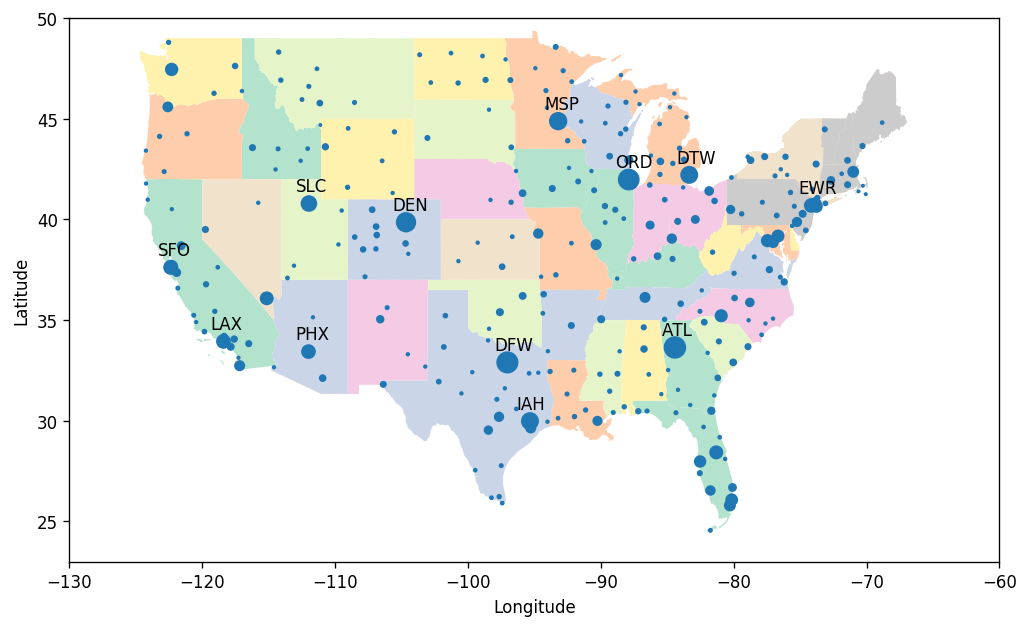

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
# plot the states map
states.plot(cmap='Pastel2', ax=ax)
# add the scatters for each airport
geo_df.plot(ax=ax, markersize=geo_df["PageRank"] * 4000)
# add text to the top 12 airports
top = pagerank.sort_values("PageRank", ascending=False).head(12)
for i in range(top.shape[0]):
    ax.text(airports.loc[list(top.index), :]["LONGITUDE"].values[i] - 1, 
            airports.loc[list(top.index), :]["LATITUDE"].values[i] + 0.6, list(top.index)[i])
ax.set_xlim([-130, -60])
ax.set_ylim([23, 50])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

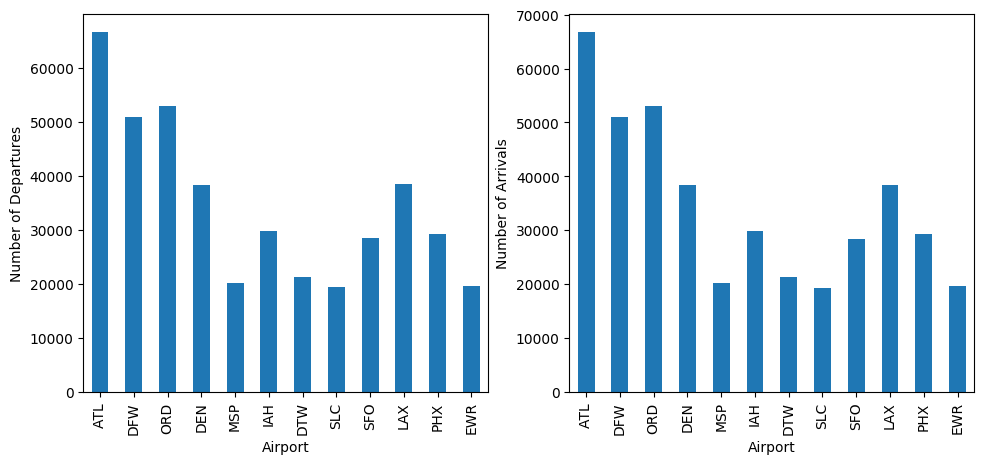

In [22]:
departure = flights["ORIGIN_AIRPORT"].value_counts().loc[top.index]
arrival = flights["DESTINATION_AIRPORT"].value_counts().loc[top.index]
# pd.DataFrame([origin, departure]).T.to_csv("Count_flights.csv", index=True)
plt.figure(figsize=(11.5,5), dpi=100)
plt.subplot(1,2,1)
departure.plot(kind="bar")
plt.xlabel("Airport"); plt.ylabel("Number of Departures")
plt.subplot(1,2,2)
arrival.plot(kind="bar")
plt.xlabel("Airport"); plt.ylabel("Number of Arrivals")
plt.show()

# References

1. Song, S., and Alabi, D. (2013), “PageRank on flights dataset,” MangoDB Blog. https://www.mongodb.com/blog/post/pagerank-on-flights-dataset.
2. Department of Transportation (2015), "2015 Flight Delays and Cancellations," Kaggle. https://www.kaggle.com/usdot/flight-delays.
3. Stewart, R. (2018), "GeoPandas 101: Plot any data with a latitude and longitude on a map," Towards Data Science. https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972.
4. Jcutrer (2020), "GeoPandas Tutorial: How to plot US Maps in Python," Jcutrer. https://jcutrer.com/python/learn-geopandas-plotting-usmaps. 
5. Sheikh, S. (2019), "The Graph Theory — An Introduction In Python," Medium. https://medium.com/apprentice-journal/the-graph-theory-an-introduction-in-python-5906d5be0e4b
